# Exercise 1 - SAKI
The purpose of this exercise is to be able to classify a set of financial transactions into these different categories.

* Income
* Private
* Living
* Standard of living
* Finance
* Traffic
* Leisure

The method we will use for this classification exercise is Naive Bayes.

We receive a document containing financial transactions that have already been classified or categorized. 
We use an implemented learning algorithm to create a classifier or classification function to classify financial transactions into the corresponding categories

This type of learning is called supervised learning. 

In our case, each transaction belongs to a single category (one-of problem)

Our goal will undoubtedly be to achieve the best possible result in order to be able to have good results on new data

For this purpose we will divide our data into 3 groups :
- training set : that will be used to train our model
- evaluation set : this one will be used to evaluate our model after training
- testing set : the latter will act as completely new data in the eyes of our algorithm and will therefore allow us to test it in a production situation
 


## Import of python librairies
    We start by importing all the librairies necessary for ourn work.
    * Data : for the manipulation of our data we will use the libraries
        - Pandas 
        - numpy 
        - nltk
    
    * Visualization : these libraries will allow us to make the visuals that will facilitate our analysis
        - seaborn
        - matplotlib
        
    * Classifier : this library will contain all the algorithms necessary for our model. 
        - scikit-learn
    


In [1]:
import numpy as np
import pandas as pd

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for text data cleaning
import string
from nltk import word_tokenize
from nltk.corpus import stopwords

# for machine learning classification
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif

# https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi?rq=1
import warnings
warnings.filterwarnings('always')

## Plan of work

We will work according to the data scientist cycle. Although the one we will propose is 
by no means absolute, because it varies a lot according to the documentation and opinions, 
but we have decided on this one, for its simplicity 

    1. Data Collection
    2. Data Cleaning
    3. Data Mining (Data Exploration)
    4. Training
    5. Evaluation & Interpretation
    6. Testing (Production) 



## I. Data Collection 
* for this simple step we will just retrieve the file that contains our data and store 
the information in a variable using the pandas library.
        by default the information is separated in a csv file by a ','
        in our case it is one ';' then we must mention this when importing
        
* We will also display a few lines in a table to make sure that the import went well.


In [2]:
# import file into a variable
training_data_set = pd.read_csv('data/training_set.csv', sep=';')
testing_data_set = pd.read_csv('data/testing_set.csv', sep=';')

# we can see the appearance of the unnamed column that was automatically added, 
# when the file was imported. We will delete the column from our data_set
column_to_drop = ['Unnamed: 0']

training_data_set.drop(column_to_drop, inplace=True, axis=1)
testing_data_set.drop(column_to_drop, inplace=True, axis=1)

# display the 5 first line of our set
training_data_set.head()



,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure


## II. Data cleaning
Cleaning up data is about making sure it is consistent, without outliers or missing values.

* one of the tasks we can do here is to convert the data type of the Betrag column into a numerical type in order to 
facilitate the different calculations that could be done when studying this variable.


In [3]:
# some value in the column Betrag have commas : 123,78 instead 123.78
training_data_set.Betrag = training_data_set["Betrag"].apply(lambda tmp: tmp.replace(',', '.'))
training_data_set.Betrag = training_data_set["Betrag"].astype(float)

testing_data_set.Betrag = testing_data_set["Betrag"].apply(lambda tmp: tmp.replace(',', '.'))
testing_data_set.Betrag = testing_data_set["Betrag"].astype(float)
    
# We can look at the type of objects in the Betrag column to confirm that the cleaning was correct.
training_data_set.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 11 columns):
Auftragskonto                        159 non-null float64
Buchungstag                          159 non-null object
Valutadatum                          159 non-null object
Buchungstext                         159 non-null object
Verwendungszweck                     159 non-null object
Beguenstigter/Zahlungspflichtiger    159 non-null object
Kontonummer                          158 non-null object
BLZ                                  158 non-null object
Betrag                               159 non-null float64
Waehrung                             159 non-null object
label                                159 non-null object
dtypes: float64(2), object(9)
memory usage: 13.7+ KB



* Text data requires special preparation before you can start using it for predictive modeling.

For text processing we will use the following steps :

1. Standardization of the text : Normalizing the text means putting it in the same case, often in lowercase. 
replace the special characters of the German language with their equivalent example : ä --> ae.
We will also delete some undesirable characters such as / or * 

2. Tokenization : It is a very simple process that divides a character string into tokens, i. e. atomic elements of the string.

3. Deleting stopwords : Here we will remove all words that have little semantic interest. example : I, me, of...



In [4]:
#1 Standardization
def standardization(sentence):
    sentence = sentence.lower()
    
    # separation of words like10103084736793Zalando
    sentence = "".join([character if character.isalpha() else " " for character in sentence])
    
    # deletion of special characters from the German language
    sentence = sentence.replace("ä", "ae").replace("ü", "ue").replace("ö", "oe").replace("ß", "ss").replace("/", " ")
    
    # deletion of all words with non-alphabetic characters example 55
    sentence = ' '.join(s for s in sentence.split() if not any(c.isdigit() for c in s))
    
    return sentence

# Buchungstext
training_data_set.Buchungstext = training_data_set["Buchungstext"].apply(lambda sentence: standardization(sentence))
testing_data_set.Buchungstext = testing_data_set["Buchungstext"].apply(lambda sentence: standardization(sentence))

# Verwendungszweck
training_data_set.Verwendungszweck = training_data_set["Verwendungszweck"].apply(lambda sentence: standardization(sentence))
testing_data_set.Verwendungszweck = testing_data_set["Verwendungszweck"].apply(lambda sentence: standardization(sentence))

#rename column Beguenstigter/Zahlungspflichtiger to simplify indexing
training_data_set.rename(index=str, columns={"Beguenstigter/Zahlungspflichtiger": "Beguenstigter"}, inplace=True)
testing_data_set.rename(index=str, columns={"Beguenstigter/Zahlungspflichtiger": "Beguenstigter"}, inplace=True)

training_data_set.Beguenstigter	 = training_data_set["Beguenstigter"].apply(lambda sentence: standardization(sentence))
testing_data_set.Beguenstigter	 = testing_data_set["Beguenstigter"].apply(lambda sentence: standardization(sentence))

# 2 & 3 Tokenization and suppression of unwanted word
ignore = stopwords.words('german')
ignore.extend(set(string.punctuation))

def tokenization(sentence):
    tokens = word_tokenize(sentence)
    clean_tokens = [word for word in tokens if word not in ignore and word.__len__() > 3]
    sentence = " ".join(clean_tokens)
    return sentence


# Buchungstext
training_data_set.Buchungstext = training_data_set["Buchungstext"].apply(lambda sentence: tokenization(sentence))
testing_data_set.Buchungstext = testing_data_set["Buchungstext"].apply(lambda sentence: tokenization(sentence))

# Verwendungszweck
training_data_set.Verwendungszweck = training_data_set["Verwendungszweck"].apply(lambda sentence: tokenization(sentence))
testing_data_set.Verwendungszweck = testing_data_set["Verwendungszweck"].apply(lambda sentence: tokenization(sentence))

# Beguenstigter
training_data_set.Beguenstigter	 = training_data_set["Beguenstigter"].apply(lambda sentence: tokenization(sentence))
testing_data_set.Beguenstigter	 = testing_data_set["Beguenstigter"].apply(lambda sentence: tokenization(sentence))

training_data_set.sample(10)



,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter,Kontonummer,BLZ,Betrag,Waehrung,label
149,89990210.0,26.01.2016,26.01.2016,lastschrift einzugsermaechtigung,visa koestr,bank nuernberg,922904916,76030080,-30.00,EUR,leisure
99,89990210.0,01.03.2016,01.03.2016,dauerauftrag,haushalt,anna fein lucas fein,DE60760300800230188170,CSDBDE71XXX,-100.00,EUR,standardOfLiving
21,89990201.0,30.05.2016,30.05.2016,lohn gehalt,gehalt adorsys gmbh notprovided kundenreferenz...,adorsys gmbh,7807800780,25190001,2000.00,EUR,income
135,89990210.0,03.02.2016,03.02.2016,lastschrift einzugsermaechtigung,amazon mktplce,amazon payments europe,DE87300308801908262006,TUBDDEDD,-20.85,EUR,leisure
143,89990210.0,01.02.2016,01.02.2016,dauerauftrag,haushalt,anna fein lucas fein,DE60760300800230188170,CSDBDE71XXX,-100.00,EUR,standardOfLiving
121,89990210.0,16.02.2016,16.02.2016,lastschrift einzugsermaechtigung,visa,bankhaus august lenz,922904916,76030080,-10.00,EUR,leisure
7,89990201.0,05.07.2016,05.07.2016,drogerie,nuernberg folgenr verf alld,drogeriemarkt sagt danke,7755566780,25190001,-28.85,EUR,standardOfLiving
48,89990210.0,27.04.2016,27.04.2016,gehalt rente,gehalt adorsys gmbh,adorsys gmbh,DE74760320009460000022,TEAMDE71,1792.73,EUR,income
60,89990210.0,04.04.2016,04.04.2016,lastschrift einzugsermaechtigung,maxx nuernberg nuernberg folgenr verfal,maxx nuernberg,DE38300800000245238803,DRESDEFF300,-89.99,EUR,finance
10,89990201.0,29.06.2016,29.06.2016,lohn gehalt,gehalt adorsys gmbh notprovided kundenreferenz...,adorsys gmbh,7807800780,25190001,2000.00,EUR,income


We can see that column "Verwendungszweck" is still cluttered with some words that do not have a huge contribution, so we will try to remove them.

The column "Buchungstext" on the other hand presents some terms that have redundant information



In [5]:
words_to_remove = "All Eur nbg Geb ref Blz gmb rse erg Fil lld xxx ccb elv bil Sekr Verf Alld gmbh ccbade spdude verfa pulsnitz maxx verfal " \
"Nsct friends verfalld California Rfalld Doris Horst Dietrich Winkl  " \
" Roethenbach  Karolinen End adorsys  Byladem sbt ssknde Beuthener str Uhr " \
"Nuerenberg Nuernber Nuernb Nuremberg gries company ultra Schnieglin Fuerth ganz bequ www seon Lombagine Sebalder" \
"Icherung vero koestr euro Folgenr Auslandsrei Deutschland Notprovided gmbAramark"


def filter(sentence, list):
    response = " ".join(word for word in sentence.split() if word not in list)
    return response

# Verwendungszweck
words_to_remove_verwendungszweck = words_to_remove.lower().split()

training_data_set.Verwendungszweck = training_data_set["Verwendungszweck"].apply(lambda sentence : filter(sentence, words_to_remove_verwendungszweck))
testing_data_set.Verwendungszweck = testing_data_set["Verwendungszweck"].apply(lambda sentence : filter(sentence, words_to_remove_verwendungszweck))

# let's also delete the terms that are repeated
training_data_set.Verwendungszweck = training_data_set["Verwendungszweck"].apply(lambda sentence : ' '.join(set(sentence.split())))
testing_data_set.Verwendungszweck = testing_data_set["Verwendungszweck"].apply(lambda sentence : ' '.join(set(sentence.split())))

# Buchungstext
word_to_remove_buchungstext = ["euro", "einzugsermaechtigung", "getraenke", "gehalt", "euroscheck", "belastung"]

training_data_set.Buchungstext = training_data_set["Buchungstext"].apply(lambda sentence : filter(sentence, word_to_remove_buchungstext))

training_data_set.sample(10)


,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter,Kontonummer,BLZ,Betrag,Waehrung,label
116,89990210.0,22.02.2016,22.02.2016,lastschrift,verfall comix nuernberg,ultra comix gmbh,DE52664926000014134905,GENODE61APP,-19.95,EUR,leisure
55,89990210.0,11.04.2016,11.04.2016,lastschrift,bears,bears friends,DE40750500000030909980,BYLADEM1RBG,-5.00,EUR,leisure
82,89990210.0,15.03.2016,15.03.2016,lastschrift,rewe danke,rewe nuernberg,DE56500101111932685105,ESSEDE5F,-22.57,EUR,standardOfLiving
81,89990210.0,15.03.2016,15.03.2016,lastschrift,aramark nuernberg,aramark gmbh teambank,DE70500202000015003825,BHFBDEFF500,-20.00,EUR,leisure
139,89990210.0,02.02.2016,02.02.2016,lastschrift,amazon mktplce,amazon payments europe,DE87300308801908262006,TUBDDEDD,-17.93,EUR,leisure
74,89990210.0,23.03.2016,23.03.2016,lastschrift,visa,amazon marketplace,922904916,76030080,-535.00,EUR,leisure
28,89990201.0,28.04.2016,28.04.2016,lohn,gehalt gutschrift kundenreferenz,adorsys gmbh,7807800780,25190001,2000.00,EUR,income
44,89990201.0,15.02.2016,15.02.2016,mieteinnahmen,gutschrift kundenreferenz mietzuschuss,isabel anna,DE31251900019736000780,VOHADE2HXXX,200.00,EUR,finance
110,89990210.0,25.02.2016,25.02.2016,lastschrift,visa,amazon marketplace,922904916,76030080,-26.30,EUR,leisure
76,89990210.0,22.03.2016,22.03.2016,lastschrift,,telecom gmbh,DE97500400000589011600,COBADEFF,-24.99,EUR,living


## III. Data Exploration

It is very often said in machine learning that :  "The quality of our input data determines the quality of our output result."

In this step, we will therefore take the time to fully understand our data, the information and the correlations between them.

Here too, there are different variants of the success of the steps to be performed during data mining.

However, we have chosen the order that seems most logical to us. 


### 1. Feature Selection

In order to reduce the size of our data, we will therefore start by selecting the variables that seem more relevant to us from our point of view than others. 

*  the "Auftragskonto" column only tells us where the different financial transactions come from and not the type of transaction itself.
    In addition, values may change from one country to another and considering these data in our model would be limited, our model to financial transactions with a very specific pattern.
    We therefore find this column not very useful for the analysis of our data and the choice of model
    
* The 2 columns "Buchungstag" and "Valutadatum" have almost the same values except for a few cases where they are different.
    Although the time of the transaction can provide information about the type of transaction. For example, 
    it is common to see the salary at the end of the month or the rent paid at the beginning of the month. 
    We will nevertheless in a concern for simplicity not to take these 2 attributes into account.
    
* he column "Beguenstigter/Zahlungspflichtiger" also reveals information that can too much stick our model to the data we currently have. (overfitting)

* 'Kontonummer', 'BLZ', 'Waehrung' do not provide important information for the classification of financial transactions.
   Indeed, these values also depend on the area where we are, and would therefore make our model too restricted, at least too adapted to our data. 
   We will therefore also delete them.

    

In [6]:
# names of the columns we want to delete 
to_drop = ['Auftragskonto', 'Buchungstag', 'Valutadatum', 'Beguenstigter', 'Kontonummer', 'BLZ', 'Waehrung']

# suppression
training_data_set.drop(to_drop, inplace=True, axis=1)
testing_data_set.drop(to_drop, inplace=True, axis=1)

# let's see what our data currently looks like
training_data_set.head()



,Buchungstext,Verwendungszweck,Betrag,label
0,lohn,gehalt gutschrift kundenreferenz,2000.00,income
1,miete,miete dauerauftrag,-670.00,living
2,bargeld,einzahlung auszahlung nuernberg,-70.00,private
3,lebensmittel,neubauer lastschrift edeka,-73.21,standardOfLiving
4,spontanausgabe,amazon,-363.00,leisure


Now that we have reduced the size of our data, we can analyze them in order to extract as much information as possible for the choice of the model we will use.



### 2. Exploration Data Analysis
Below are the steps involved to understand, and prepare our data for building our predictive model.
    
    a. Variable Identification
    b. Univariate Analysis
    c. Bi-variate Analysis
    d. Missing values treatment
    e. Outlier treatment
   
##### a. Variable Identification

* Type of variable

> 1- Predictor Variable
- Buchungstext
- verwendungszweck
- Beguenstigter/Zahlungspflichtiger
- Betrag

> 2- Target variable
- label


* Data Type

> 1- Character
- Buchungstext
- Verwendungszweck
- Beguenstigter/Zahlungspflichtiger
- label

> 2- Numeric
- Betrag



##### b. Univariate Analysis
* This part will allow us to explore the variables one by one. The analysis method we will use will depend 
on the nature of our variable (if it is a continuous variable for example).

* For categorical variables (Buchungstext, Verwendungszweck, Beguenstigter/Zahlungspflichtiger) , we’ll use frequency table to understand distribution of each category. We can also read as percentage of values under each category.
Bar chart or pie chart can be used as visualization.



* let's also analyze the frequency of the values of the variable "Buchungstext".


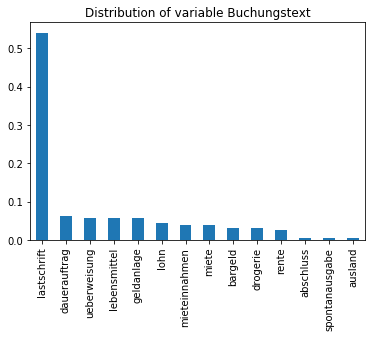

In [7]:
# bar chart for variable Buchungstext
training_data_set['Buchungstext'].value_counts(normalize=True).plot(kind='bar', width=0.5)
plt.title("Distribution of variable Buchungstext")
plt.show()
        


* frequency table for the variable "Verwendungszweck".



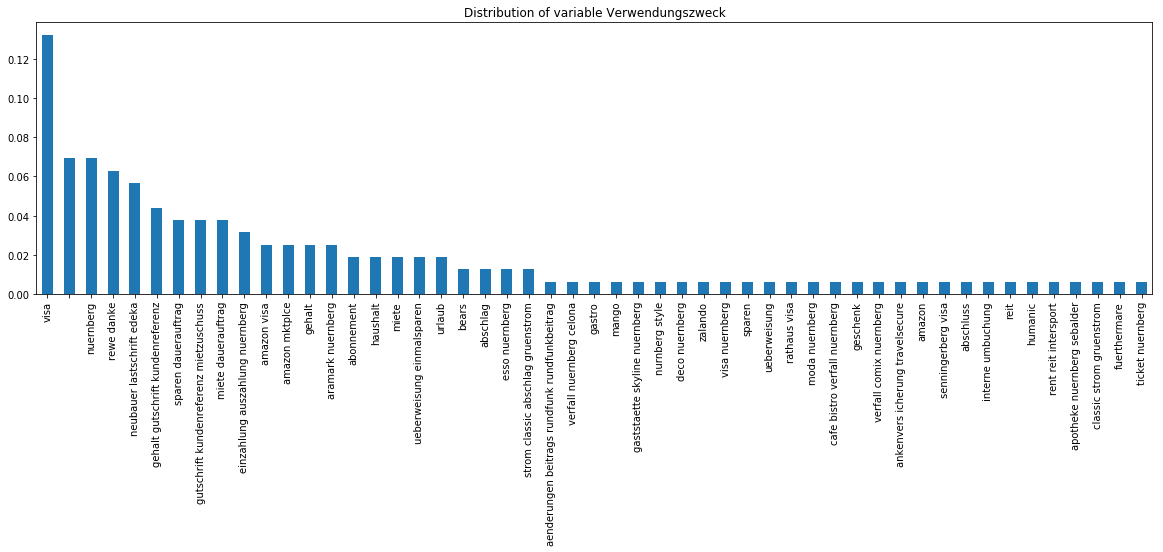

In [8]:
# bar chart for variable Verwendungszweck
training_data_set['Verwendungszweck'].value_counts(normalize=True).plot(kind='bar', width=0.5, figsize=(20, 5))
plt.title("Distribution of variable Verwendungszweck")
plt.show()



* Frequency table for the label


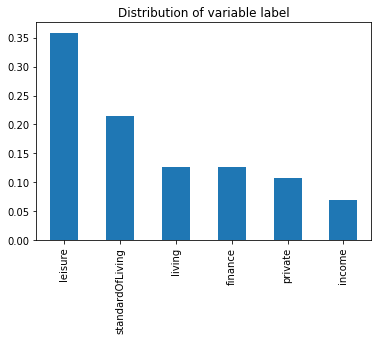

In [9]:
# bar chart for distribution of variable label
training_data_set['label'].value_counts(normalize=True).plot(kind='bar', width=0.5)
plt.title("Distribution of variable label")
plt.show()


Empirical distribution of the Betrag variable

By observing this distribution which is quite similar to Gauss. We are already tempted to think about using the Gaussian implementation of Naives Baye


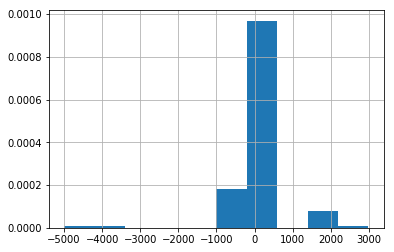

In [10]:
training_data_set["Betrag"].hist(density=True)
plt.show()        
        

#### c. Bi-variate Analysis
* After observing the distributions of the different variables, which have already allowed us to identify some hypotheses on the choice of the model.

* The notion of the relationship between variables is called correlation. To say that two variables are correlated means 
that if we know the value of one variable, then it is possible to have an indication (more or less precise) 
on the value of another variable.

* Here, we look for association and disassociation between variables at a pre-defined significance level. 
We can perform bi-variate analysis for any combination of categorical and continuous variables.

> 2 Continuous  variable --> scatterplot

> 2 Categorical variable -->  Two-way table, Chi-2

> 1 Categorical and 1 Continuous --> ANOVA


In [11]:
def two_way_table(df, labelX, labelY):
    Y = labelX
    X = labelY
    
    return df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")


def tableWithChiSquare(df, labelX, labelY):
    Y = labelX
    X = labelY
    
    cont = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
    
    tx = cont.loc[:,["Total"]]
    ty = cont.loc[["Total"],:]
    n = len(df)
    indep = tx.dot(ty) / n

    c = cont.fillna(0) # On remplace les valeurs nulles par 0
    measure = (c-indep)**2/indep
    xi_n = measure.sum().sum()
    table = measure/xi_n
    sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
    plt.show()
    
    



Let's look at a correlation between the variables "Buchungstext" and "label".

* As we can see on the diagram, with the exception of "Lastschrift (Einzugsermächtigung)", each value of the variable 
"Buchungstext" is assigned to a single label value showing a correlation between the 2 variables.


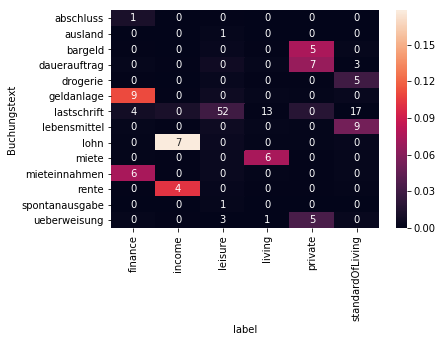

In [12]:
tableWithChiSquare(training_data_set, "label", "Buchungstext")



Let's look at a correlation between the variables "Verwendungszweck" and "label".

* This table also shows us a certain correlation between the keywords in the Verwendungszweck column and the corresponding category.

* this could be in combination with the Buchungstext variable a way to determine the type of a transaction



In [13]:
cont = two_way_table(training_data_set, "label", "Verwendungszweck")
cont


label,finance,income,leisure,living,private,standardOfLiving,Total
Verwendungszweck,,,,,,,
,NaN,NaN,3.0,4.0,2.0,2.0,11
abonnement,NaN,NaN,3.0,NaN,NaN,NaN,3
abschlag,NaN,NaN,NaN,2.0,NaN,NaN,2
abschluss,1.0,NaN,NaN,NaN,NaN,NaN,1
aenderungen beitrags rundfunk rundfunkbeitrag,NaN,NaN,NaN,1.0,NaN,NaN,1
amazon,NaN,NaN,1.0,NaN,NaN,NaN,1
amazon mktplce,NaN,NaN,4.0,NaN,NaN,NaN,4
amazon visa,NaN,NaN,4.0,NaN,NaN,NaN,4
ankenvers icherung travelsecure,1.0,NaN,NaN,NaN,NaN,NaN,1


Look for a correlation between the variable "Verwendungszweck" and "Buchungstext"

* As we have already seen during the analysis of the distribution of the variable "Verwendungszweck", 
this table just confirms that the combination of Feature from the "Verwendungszweck" and "Buchungstext" columns 
would be a good way to more or less find a balance in the classification of most transactions

In [14]:
cont = two_way_table(training_data_set, "Verwendungszweck", "Buchungstext")
cont


Verwendungszweck,,abonnement,abschlag,abschluss,aenderungen beitrags rundfunk rundfunkbeitrag,amazon,amazon mktplce,amazon visa,ankenvers icherung travelsecure,apotheke nuernberg sebalder,...,ticket nuernberg,ueberweisung,ueberweisung einmalsparen,urlaub,verfall comix nuernberg,verfall nuernberg celona,visa,visa nuernberg,zalando,Total
Buchungstext,,,,,,,,,,,,,,,,,,,,,
abschluss,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
ausland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
bargeld,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
dauerauftrag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,10
drogerie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
geldanlage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,9
lastschrift,7.0,3.0,2.0,NaN,1.0,NaN,4.0,4.0,1.0,1.0,...,1.0,NaN,NaN,NaN,1.0,1.0,21.0,1.0,NaN,86
lebensmittel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
lohn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


#### d. Missing values treatment
* The absence of some data in our dataset may reduce the accuracy of our model or may lead to a biased model 
because we have not properly analyzed the behaviour and relationship with the other variables. 
This can lead to prediction or misclassification.

* In the case of a training data set, we can see some lines that have missing values for the x attribute, 
however we will not delete these lines because we could classify them with the Buchungstext attribute.



#### e. Outlier treatment

* An outlier can be a value that is clearly false or a value that "stands out from the crowd", but not necessarily false.
In this case, we will study the distribution of the Betrag value in order to detect possible outliers and remove them from the training set.

* When observing the Boxplot of the Betrag variable, we can see less that many values could be considered as outliers (-5000, -4000, 2000, 3000).

* But after observing the scatter plot, we can clearly see that only 2 values (-5000, -4000) seem to stand out from the other values in their category.

* However, we will only delete the value -5000 because it really seems to be outlier. Indeed, it is not common to make an expense of 5000 euros as a quotient expense.
 

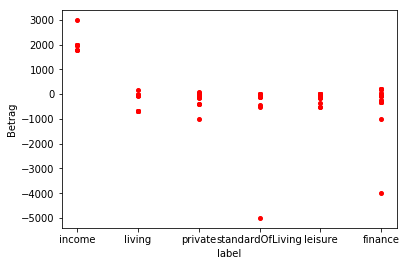

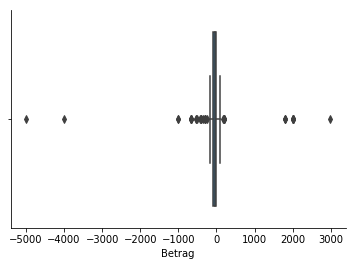

In [15]:
#scatter plot
plt.xlabel('label')
plt.ylabel('Betrag')
plt.plot(training_data_set['label'], training_data_set['Betrag'], 'ro', markersize=4)
plt.show()


#box plot
sns.boxplot(training_data_set['Betrag'])
sns.despine()

#delete outlier -5000
training_data_set = training_data_set[training_data_set.Betrag != -5000]



### 3. Feature extraction
Now that our analysis is complete, we have decided to use the variables "Verwendungszweck" and "Buchungstext" as input for categorization with the Bernoulli model.

Therefore, we must then build the final matrix that will be used for the training of our model.

First we will create a matrix with as a column the different words that appear in the columns "Verwendungszweck" and "Buchungstext".


In [16]:

def get_frequency_matrix(df):
    count_vect = CountVectorizer()
    frequency_matrix = count_vect.fit_transform(df)
    frequency_matrix_mame = count_vect.get_feature_names()
    return pd.DataFrame(data=frequency_matrix.toarray(), columns=frequency_matrix_mame)



# initialization of the dataframe that will have the frequency matrix
df_buchungstext_verwendungszweck = pd.DataFrame()
df_test_buchungstext_verwendungszweck = pd.DataFrame()


# we put the different values present in the columns "Verwendungszweck" and "Buchungstext"
df_buchungstext_verwendungszweck["fusion"] = training_data_set.Buchungstext + " " + training_data_set.Verwendungszweck
df_test_buchungstext_verwendungszweck["fusion"] = testing_data_set.Buchungstext + " " + testing_data_set.Verwendungszweck


df_buchungstext_verwendungszweck = get_frequency_matrix(df_buchungstext_verwendungszweck.fusion)
df_test_buchungstext_verwendungszweck = get_frequency_matrix(df_test_buchungstext_verwendungszweck.fusion)


# let's make sure our matrix looks a little bit like what we want
df_buchungstext_verwendungszweck.sample(5)



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to repres

,abonnement,abschlag,abschluss,aenderungen,amazon,ankenvers,apotheke,aramark,ausland,auszahlung,...,strom,style,ticket,travelsecure,ueberweisung,umbuchung,urlaub,verfall,visa,zalando
108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
133,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We will now also encode the different categories and reconstruct our final table as we final table with all features and the associated label.


In [17]:
training_labels = pd.DataFrame()
test_labels = pd.DataFrame()

training_labels["label"] = training_data_set.label.map({'income':0, 'private':1, 'living':2, 'standardOfLiving':3, 'finance':4, 'leisure':5})
test_labels["label"] = testing_data_set.label.map({'income':0, 'private':1, 'living':2, 'standardOfLiving':3, 'finance':4, 'leisure':5})

df_buchungstext_verwendungszweck.reset_index(drop=True, inplace=True)
df_test_buchungstext_verwendungszweck.reset_index(drop=True, inplace=True)

training_labels.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)

training_features_labels = pd.concat([df_buchungstext_verwendungszweck, training_labels], axis=1, sort=False)
test_features_labels = pd.concat([df_test_buchungstext_verwendungszweck, test_labels], axis=1, sort=False)

training_features_labels.head()


,abonnement,abschlag,abschluss,aenderungen,amazon,ankenvers,apotheke,aramark,ausland,auszahlung,...,style,ticket,travelsecure,ueberweisung,umbuchung,urlaub,verfall,visa,zalando,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


As we can see from the table we have more than 60 features, which is clearly a lot considering the amount of data we have for training our model. 
We will then make the selection using the Mutual Information method, 
which measures how much the presence or absence of a term can contribute to making the classification correct


In [18]:
training_labels["label"] = training_features_labels["label"]
test_labels["label"] = test_features_labels["label"]

training_features = training_features_labels.drop(columns=["label"])
test_features = test_features_labels.drop(columns=["label"])

feature_mutual_info = mutual_info_classif(training_features, training_labels["label"], random_state=42, n_neighbors=4)

features_column = list(training_features)

feature_mutual_info = list(zip(features_column, feature_mutual_info))
feature_mutual_info.sort(key=lambda row: row[1], reverse=True) 

feature_names = [name for name, score in feature_mutual_info if score > 0]

training_features = training_features[feature_names]
test_features = test_features.reindex(columns=feature_names)
test_features.fillna(0, inplace=True)

# let's take a look at some lines from our final table 
training_features.sample(5)



,lastschrift,gehalt,visa,gutschrift,neubauer,rewe,kundenreferenz,rente,mieteinnahmen,reit,...,comix,haushalt,abschluss,mango,skyline,gruenstrom,humanic,bistro,nurnberg,mktplce
51,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
103,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## IV. Training and Evaluation
* In order to properly test our model, it would be nice to divide our training set into 2 parts, 
one for model training and another part to evaluate the model and see its accuracy.

* Accuracy: Measures how often the classifier makes the correct prediction. 
It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

* Precision: Told us what proportion of transactions that we classified as a category were actually in that category.  
This is a relationship between true positives (well ranked transactions) and all positives.
Precision = [True Positives/(True Positives + False Positives)]

* Recall(sensitivity): Tells us what proportion of transactions that were in a category and that were well ranked
Recall = [True Positives/(True Positives + False Negatives)]



In [19]:
# split the data_set into 2 sets (training_set and evaluation_set)
X_train, X_eval, Y_train, Y_eval = train_test_split(training_features, training_labels["label"], random_state=42, test_size=0.2, shuffle=True)

clf = BernoulliNB()
clf.fit(X_train, Y_train)

eval_predict_target = clf.predict(X_eval)
print("Accuracy: %0.3f " % np.mean(eval_predict_target == Y_eval))

precisionScore = metrics.precision_score(Y_eval, y_pred=eval_predict_target, average='macro')
print("Precision: %0.3f " % precisionScore)

recallScore = metrics.recall_score(Y_eval, y_pred=eval_predict_target, average='macro')
print("Recall: %0.3f " % recallScore)

f1score = metrics.f1_score(Y_eval, eval_predict_target, average='macro')
print("F1 score: %0.3f " % f1score)



Accuracy: 0.750 
Precision: 0.808 
Recall: 0.724 
F1 score: 0.739 


## V. Testing

Now we will use our test data to measure the performance of our model on "non-annotated" data.


In [20]:
test_predict_target = clf.predict(test_features)
print("Accuracy: %0.3f " % np.mean(test_predict_target == test_labels["label"]))

precisionScore = metrics.precision_score(test_labels["label"], y_pred=test_predict_target, average='macro')
print("Precision: %0.3f " % precisionScore)

recallScore = metrics.recall_score(test_labels["label"], y_pred=test_predict_target, average='macro')
print("Recall: %0.3f " % recallScore)

f1score = metrics.f1_score(Y_eval, eval_predict_target, average='macro')
print("F1 score: %0.3f " % f1score)

Accuracy: 0.980 
Precision: 0.981 
Recall: 0.972 
F1 score: 0.739 
